In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os

from IPython.display import Image
from IPython.display import display

# numpy 1.23.5
import numpy as np

# pandas 1.5.3
import pandas as pd

# scikit-learn 1.2.2
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
# from cycler import cycler

# matplotlib  3.7.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
# load utility classes/functions e.g., plot_decision_regions()
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")

from lab04lib import *

import warnings
warnings.filterwarnings("ignore")

### Logistic Regression

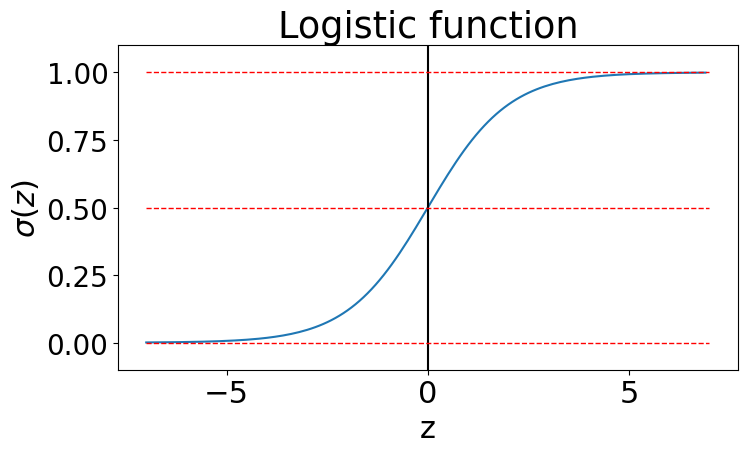

In [3]:
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma = logistic(z)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(z, sigma)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.title('Logistic function')
plt.hlines(y=1.0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0.5, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.tight_layout()
for item in (ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('./output/fig-logistic.png', dpi=300)
plt.show()

![](https://nthu-datalab.github.io/ml/labs/06_Logistic-Regression_Metrics/fig-logistic-regression.png)

### Predicting Class-Membership Perobability

One benefit of using Logistic Regression is that it is able to output the **class-membership probability** (i.e., probability of a class to which a point x belongs) via $σ(w⊤x)$ and $1−σ(w⊤x)$.

In fact, there are many applications where we are not only interested in predicting class labels, but also in estimating the class-membership probability. For example, in weather forecasting, we are interested not only if it will rain tomorrow but also the chance of raining. Similarly, when diagnosing disease we usually care about the chance that a patient has a particular disease given certain symptoms. This is why Logistic Regression enjoys wide popularity in the field of medicine.

### Training a Logistic Regression Model with Scikit-learn

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

# for simplicity, consider only two features and two classes

X = df[['Petal length', 'Petal width']].values[50:150]
y, y_label = pd.factorize(df['Class label'].values[50:150])

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# Standardize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [0 1] (mapped from ['Iris-versicolor' 'Iris-virginica'])


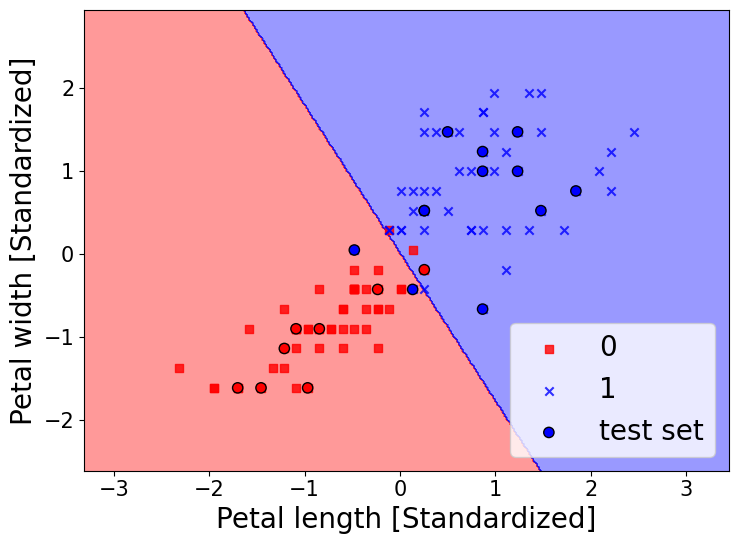

In [5]:
lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                                    y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='lower right')
plt.tight_layout()
plt.legend(loc=4, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-2.png', dpi=300)
plt.show()

In [6]:
test_idx = 1
print('Correct label: %s\n' % y_label[y_test[test_idx]])

prob = lr.predict_proba(X_test_std[test_idx, :].reshape(1, -1))

print('Prob for class %s: %.2f' % (y_label[0], prob[:, 0]))
print('Prob for class %s: %.2f' % (y_label[1], prob[:, 1]))

Correct label: Iris-virginica

Prob for class Iris-versicolor: 0.01
Prob for class Iris-virginica: 0.99


### Regularization

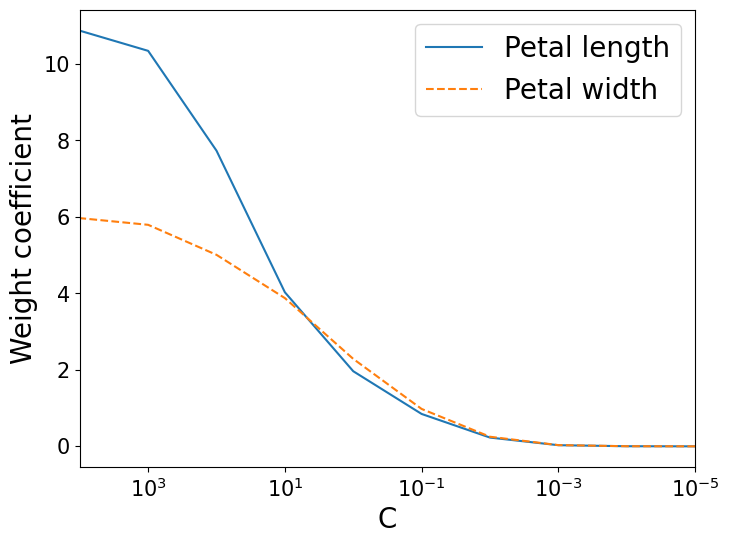

In [7]:
weights, params = [], []
for c in np.arange(-5, 5, dtype='float32'):
    lr = LogisticRegression(C = 10**c, random_state = 0, solver = "liblinear")
    lr.fit(X_train_std, y_train)
    # get the coefficients of w
    weights.append(lr.coef_[0])
    params.append(10**c)

fig, ax = plt.subplots(figsize=(8,6))
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1],
         label='Petal width', linestyle='--')
plt.xlim(10**4, 10**-5)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Weight coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend(loc=1, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
plt.show()

### Evaluation Metrics for Binary Classifiers

So far, we evaluate the performance of a classifier using the **accuracy** metric. Although accuracy is a general and common metric, there are several other evaluation metrics that allow us to quantify the performance of a model from different aspects.

### Confusion Matrix

Before we get into the details of different evaluation metrics, let's print the so-called **confusion matrix**, a square matrix that reports the counts of the true positive, true negative, false positive, and false negative predictions of a classifier, as shown below:

![](https://nthu-datalab.github.io/ml/labs/06_Logistic-Regression_Metrics/fig-confusion.png)

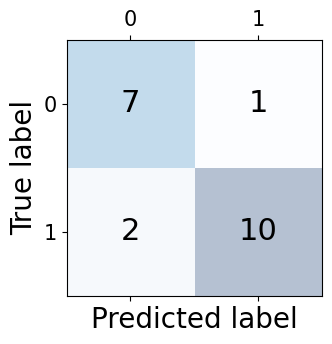

In [8]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

The meaning of each entry in the above confusion matrix is straightforward. For example, the cell at $(1,0)$ means that $2$
positive testing points are misclassified as negative. Confusion matrix helps us know not only the count of **how many** errors but **how** they are wrong. Correct predictions counts into the diagonal entries. A good performing classifier should have a confusion matrix that is a diagonal matrix which means that the entries outside the main diagonal are all zero.
The **error rate (ERR)** and **accuracy (ACC)** we have been using can be defined as follows:

$$ERR = \frac{FP+FN}{TP + TN + FP + FN},\enspace\text{ (the lower, the better)}$$

$$ACC = \frac{TP+TN}{TP + TN + FP + FN} = 1-ERR.\enspace\text{ (the higher, the better)}$$

### True and False Positive Rate

The true positive rate (TPR) and false positive rate (FPR) are defined as:

$$TPR = \frac{TP}{TP + FN}.\enspace\text{ (the higher, the better)}$$

$$FPR = \frac{FP}{FP + TN},\enspace\text{ (the lower, the better)}$$

TPR and FPR are metrics particularly useful for tasks with **imbalanced classes**. For example, if we have 10% positive and 90% negative examples in the training set, then a dummy classifier that always give negative predictions will be able to achieve 90% accuracy. The accuracy metric is misleading in this case. On the other hand, by checking the TPR which equals to 0%, we learn that the dummy classifier is not performing well.

### Precision, Recall, and $F1$-Score

$$PRE = \frac{TP}{TP + FP},\enspace\text{ (the higher, the better)}$$

$$REC = \frac{TP}{TP + FN} = TPR.\enspace\text{ (the higher, the better)}$$

**$F1$-score**:

$$F_1 = 2\frac{(PRE * REC)}{PRE+REC},\enspace\text{ (the higher, the better)}$$

### Evaluation Metrics for Soft Classifiers

![](https://nthu-datalab.github.io/ml/labs/06_Logistic-Regression_Metrics/fig-roc-threshold.png)

### Receiver Operating Characteristic (ROC) Curve

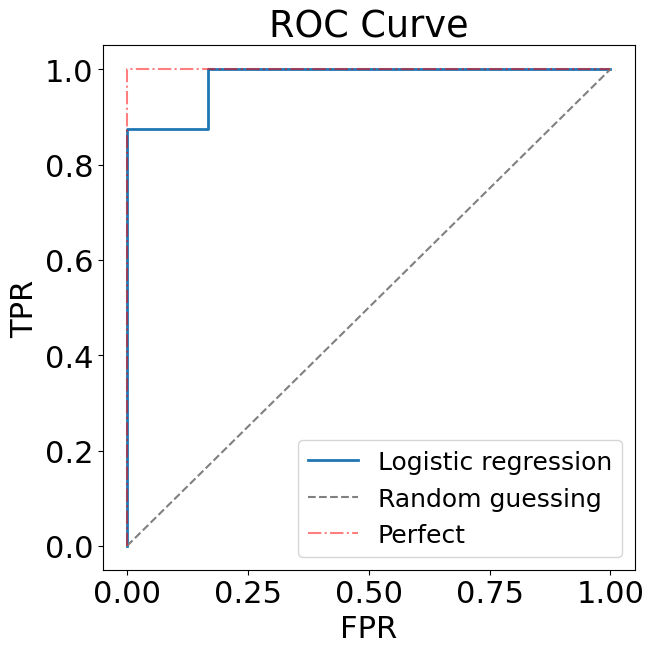

In [9]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

fig = plt.figure(figsize=(7,7))

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

probas = lr.predict_proba(X_test_std)

## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-roc-lg.png', dpi=300)
plt.show()

### Model Comparison

![](https://nthu-datalab.github.io/ml/labs/06_Logistic-Regression_Metrics/fig-roc-compare.png)

### Area Under the Curve (AUC)

In [10]:
print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.98


### Evaluation Metrics for Multiclass Classification

#Training data points: 16 + 33 + 31 = 80
#Testing data points: 4 + 17 + 19 = 40
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'])


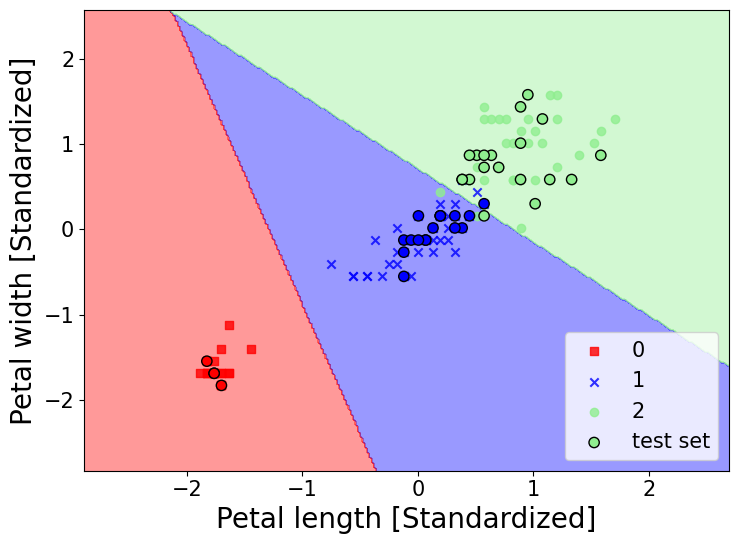

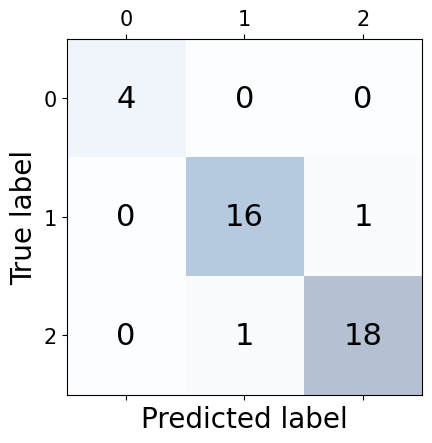

[Precision]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[Recall]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[F1-score]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96


In [11]:
# prepare datasets

X = df[['Petal length', 'Petal width']].values[30:150,]
y, y_label = pd.factorize(df['Class label'].values[30:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

print('#Training data points: %d + %d + %d = %d' % ((y_train == 0).sum(),
                                                    (y_train == 1).sum(),
                                                    (y_train == 2).sum(),
                                                     y_train.size))
print('#Testing data points: %d + %d + %d = %d' % ((y_test == 0).sum(),
                                                    (y_test == 1).sum(),
                                                    (y_test == 2).sum(),
                                                     y_test.size))
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# standarize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# training & testing

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear", multi_class = "ovr")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-3.png', dpi=300)
plt.show()

# plot confusion matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion-3.png', dpi=300)
plt.show()

# metrics

print('[Precision]')
p = precision_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (p[0], p[1], p[2]))
p = precision_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % p)
p = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % p)

print('\n[Recall]')
r = recall_score(y_true=y_test, y_pred=y_pred,average=None)
print('Individual: %.2f, %.2f, %.2f' % (r[0], r[1], r[2]))
r = recall_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % r)
r = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % r)

print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (f[0], f[1], f[2]))
f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % f)

### <center>**Assignment**</center>

### Goal
Predict the presence or absence of cardiac arrhythmia in a patient

### Read this note carefully

- Submit to **eeclass** with your code file, the filename format should be Lab06_{student_id}.ipynb. The notebook should contain
    1. Loading of dataset
    2. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)
    3. Building of a self-designed Logistic Regression model (Complete the TODO parts provided below)
    4. Plotting the loss curve.
    5. Plotting of the confusion matrix. (**Label 0 as positive**)
    6. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75
- Deadline: **2023-10-26(Thr) 23:59**
- Please make sure that we can rerun your code


### Dataset

The [Arrhythmia](https://archive.ics.uci.edu/ml/datasets/Arrhythmia) dataset from UCI repository contains 280 variables collected from 452 patients. Its information helps in distinguishing between the presence and absence of cardiac arrhythmia and in classifying arrhytmia in one of the 16 groups. In this homework, we will just focus on building a Logistic Regression model that can classify between the presence and absence of arrhythmia.

Original class 1 refers to 'normal' ECG which we will regard as 'absence of arrhythmia' and the rest of the classes will be 'presence of arrhythmia'.

In [12]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


How big is the dataset?

In [13]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


The last column of the dataset is the class label. It contains the 16 ECG classifications:

In [14]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

Let's make that column (class label) dichotomous.

Value is 0 if ECG is normal, 1 otherwise

In [15]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

Are the groups balanced?

In [16]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?'

To make the preprocessing simpler, let's just retain the columns with numeric values.


In [17]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [18]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [19]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [20]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [21]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Please continue working from here.


In [25]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        # TODO
        pass

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        pass

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        pass